In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os, re, random
import numpy as np
import torch.nn.functional as F

# --- DO NOT CHANGE THIS SEED ---
# Set random seed for reproducibility and scoring
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
# -------------------------------

In [70]:
# Generate 100 sine functions with different a,b,c parameters and random noise
def sine(a,b,c,x):
    return a * np.sin(b * x + c)

x_data = np.arange(0,10,0.001)
a_list = np.linspace(0,10,100)
b_list = np.linspace(0.1,6,100)
c_list = np.linspace(0,5,100)

my_a = random.choice(a_list)
my_b = random.choice(b_list)
my_c = random.choice(c_list)

y_data = sine(my_a, my_b, my_c, x_data) + my_a * np.random.rand(len(x_data))

In [71]:
class sine_nn(nn.Module):
    def __init__(self, data_length, embed_dim, hidden_dim, num_params, dropout=0.5):
        super(sine_nn, self).__init__()

        self.embedding = nn.EmbeddingBag(data_length, embed_dim, sparse=False, mode="mean")
        self.hidden = nn.Linear(embed_dim, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.output = nn.Linear(hidden_dim, num_params)

    def forward(self, data, offsets):
        # 1. Apply embedding layer
        embedded = self.embedding(data, offsets)

        # 2. Pass through hidden layer and ReLU activation
        hidden_out = F.relu(self.hidden(embedded))

        # 3. Apply dropout
        hidden_out = self.dropout(hidden_out)

        # 4. Pass through the output layer
        output = self.output(hidden_out)

        return output

In [72]:
# Model Hyperparameters (Provided)
EMBED_DIM = 256
HIDDEN_DIM = 256
NUM_PARAMS = 3 
DROP_RATE = 0.2
learning_rate = 1e-4
epochs = 100
offsets = torch.tensor([0], dtype=torch.int64)

# Instantiate the model (using your definition above)
model = sine_nn(len(x_data), embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_params=NUM_PARAMS, dropout=DROP_RATE)

In [74]:
def loss_fun(y_true, y_pred):
  return torch.mean((y_true - y_pred) ** 2)

my_model =  nn.Sequential(
            nn.Linear(len(x_data), 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 3)  # Output layer with 3 parameters (a, b, c)
        )

my_model.train()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for i in range(epochs):
  optimizer.zero_grad()
  pred_a, pred_b, pred_c = my_model(torch.tensor(x_data))
  y_pred = sine(pred_a, pred_b, pred_c, x_data)
  loss = loss_fun(y_data, y_pred)
  loss.backward()
  optimizer.step()

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [271]:
@jax.jit
def compute_metrics(*, state, batch, label):
    logits = state.apply_fn({'params': state.params}, batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(
        logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [272]:
init_rng = jax.random.PRNGKey(0)

learning_rate = 0.01

state = create_train_state(dnn, init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [273]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [274]:
n_epochs = 50

In [275]:
step = 0

for _ in range(n_epochs):
  for batch, label in zip(X_train, y_train):

    # Run optimization steps over training batches and compute batch metrics
    state = train_step(state, batch, label) # get updated train state (which contains the updated parameters)
    state = compute_metrics(state=state, batch=batch, label=label) # aggregate batch metrics

    if (step+1) % n_batches == 0: # one training epoch has passed
      for metric,value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
      state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

      # Compute metrics on the test set after each training epoch
      test_state = state
      test_state = compute_metrics(state=test_state, batch=X_tst, label=y_tst)

      for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)

      print(f"train epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
      print(f"test epoch: {(step+1) // n_batches}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")
    step += 1

E0607 02:58:17.735238   70330 buffer_comparator.cc:157] Difference at 160: -0.109804, expected 3.58554
E0607 02:58:17.735269   70330 buffer_comparator.cc:157] Difference at 161: -0.325295, expected 6.42086
E0607 02:58:17.735271   70330 buffer_comparator.cc:157] Difference at 162: 0.339538, expected 6.12519
E0607 02:58:17.735273   70330 buffer_comparator.cc:157] Difference at 163: 0.0654982, expected 5.53681
E0607 02:58:17.735274   70330 buffer_comparator.cc:157] Difference at 164: 0.231911, expected 4.23559
E0607 02:58:17.735275   70330 buffer_comparator.cc:157] Difference at 165: -0.116383, expected 4.05505
E0607 02:58:17.735277   70330 buffer_comparator.cc:157] Difference at 166: -0.502399, expected 5.53238
E0607 02:58:17.735278   70330 buffer_comparator.cc:157] Difference at 167: 0.0365431, expected 4.60062
E0607 02:58:17.735279   70330 buffer_comparator.cc:157] Difference at 168: 0.72855, expected 6.13015
E0607 02:58:17.735281   70330 buffer_comparator.cc:157] Difference at 169: 0.

train epoch: 1, loss: 3.355041265487671, accuracy: 77.5
test epoch: 1, loss: 3.552858829498291, accuracy: 90.0
train epoch: 2, loss: 0.28252241015434265, accuracy: 97.5
test epoch: 2, loss: 3.254927396774292, accuracy: 90.0
train epoch: 3, loss: 0.0315912701189518, accuracy: 100.0
test epoch: 3, loss: 2.5205159187316895, accuracy: 90.0
train epoch: 4, loss: 0.027580611407756805, accuracy: 100.0
test epoch: 4, loss: 1.8506206274032593, accuracy: 90.0
train epoch: 5, loss: 0.026313479989767075, accuracy: 100.0
test epoch: 5, loss: 1.315142035484314, accuracy: 90.0
train epoch: 6, loss: 0.025263512507081032, accuracy: 100.0
test epoch: 6, loss: 0.9123055338859558, accuracy: 90.0
train epoch: 7, loss: 0.024470720440149307, accuracy: 100.0
test epoch: 7, loss: 0.8094615936279297, accuracy: 90.0
train epoch: 8, loss: 0.023810558021068573, accuracy: 100.0
test epoch: 8, loss: 0.7859393954277039, accuracy: 90.0
train epoch: 9, loss: 0.02297138422727585, accuracy: 100.0
test epoch: 9, loss: 0.8

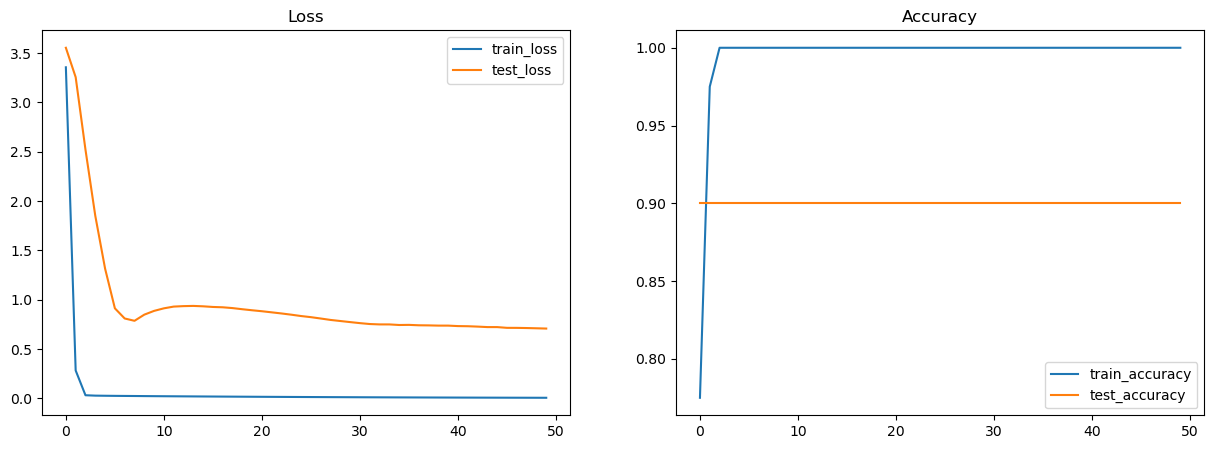

<Figure size 640x480 with 0 Axes>

In [276]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

# 2: Is your trained model confident that any of the stars in your test set are part of M4?

Yes, as seen above, my model is very confident that many of the stars are in M4, since there is a large spike at 4 on the plot above.

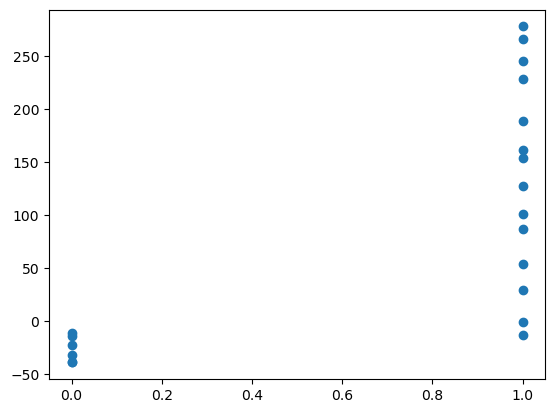

In [279]:
outputs = state.apply_fn({'params': state.params}, X_tst)
plt.scatter(a_list, jnp.diff(outputs, axis=1)[0])
plt.scatter(b_list, jnp.diff(outputs, axis=1)[1])
plt.scatter(c_list, jnp.diff(outputs, axis=1)[2])